## Simple space mission analysis with PyStarburst and Galaxy

### Sign up for a Galaxy account & setup the sample catalog

You'll need a [Starburst Galaxy]("https://www.starburst.io/platform/starburst-galaxy/start/") account with a sample catalog [setup]("https://docs.starburst.io/starburst-galaxy/catalogs/sample.html") alongside a writeable catalog (suggested to use an object-store based catalog) for storing the results.

In [13]:
# Install the library

%pip install https://starburstdata-downloads.s3.amazonaws.com/pystarburst/0.5.0/pystarburst-0.5.0-py3-none-any.whl
%pip install pandas matplotlib

  Using cached https://starburstdata-downloads.s3.amazonaws.com/pystarburst/0.5.0/pystarburst-0.5.0-py3-none-any.whl (121 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/24/db/6ec78a4f10673a641cdb11694c2de2f64aa00e838551248cb11b8b057440/matplotlib-3.8.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/5b/ac/26fa1057f62beaa2af4c55c6ac733b114a403b746cfe0ce3dc6e4aec921a/contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency informatio

In [21]:
# Define Connection Properties
# You can get the host and other information from the Partner Connect -> PyStarburst section in Galaxy

import getpass

host = "officialdemo-aws-us-east-2-free.trino.galaxy.starburst.io"
username = "yash.balar@starburst.io/accountadmin"
password = getpass.getpass("Password")

In [22]:
# Import dependencies

from pystarburst import Session
from pystarburst import functions as f
from pystarburst.functions import col

import trino

session_properties = {
    "host":host,
    "port": 443,
    # Needed for https secured clusters
    "http_scheme": "https",
    # Setup authentication through login or password or any other supported authentication methods
    # See docs: https://github.com/trinodb/trino-python-client#authentication-mechanisms
    "auth": trino.auth.BasicAuthentication(username, password)
}

session = Session.builder.configs(session_properties).create()

In [23]:
# Validate connectivity to the cluster

session.sql("select 1 as b").collect()

[Row(b=1)]

In [24]:
# Let's understand the data

df_missions = session.table("sample.demo.missions")

print(df_missions.schema)
df_missions.show()

StructType([StructField('id', IntegerType(), nullable=True), StructField('company_name', StringType(), nullable=True), StructField('location', StringType(), nullable=True), StructField('date', StringType(), nullable=True), StructField('detail', StringType(), nullable=True), StructField('status_rocket', StringType(), nullable=True), StructField('cost', DoubleType(), nullable=True), StructField('status_mission', StringType(), nullable=True)])
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"id"  |"company_name"  |"location"                                          |"date"                      |"detail"                                            |"status_rocket"  |"cost"  |"status_mission"  |
---------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
#
# There's some data clean up needed - plus we want to only look at missions since the year 2000
#

from datetime import datetime

# We can add arbitrary SQL expressions as needed
df_missions = df_missions.with_column("date", f.sql_expr("COALESCE(TRY(date_parse(\"date\", '%a %b %d, %Y %H:%i UTC')), NULL)"))

print(df_missions.schema)

df_missions = df_missions\
    .filter(col("date") > datetime(2000, 1, 1))\
    .sort(col("date"), ascending=True)

df_missions.show()

StructType([StructField('id', IntegerType(), nullable=True), StructField('company_name', StringType(), nullable=True), StructField('location', StringType(), nullable=True), StructField('detail', StringType(), nullable=True), StructField('status_rocket', StringType(), nullable=True), StructField('cost', DoubleType(), nullable=True), StructField('status_mission', StringType(), nullable=True), StructField('date', TimestampNTZType(), nullable=True)])
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"id"  |"company_name"  |"location"                                         |"detail"                          |"status_rocket"  |"cost"  |"status_mission"  |"date"               |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1213 

In [26]:
#
# Next we'll do a basic aggregation for summarization
#

df_summarized = df_missions\
    .group_by("company_name")\
    .count()\
    .rename("count", "num_missions")\
    .sort(col("num_missions").desc())
df_summarized.show(n=100)

-----------------------------------
|"company_name"  |"num_missions"  |
-----------------------------------
|CASC            |179             |
|Arianespace     |166             |
|ULA             |140             |
|SpaceX          |100             |
|VKS RF          |97              |
|ISRO            |62              |
|Roscosmos       |54              |
|Northrop        |51              |
|MHI             |50              |
|Boeing          |46              |
|NASA            |40              |
|Sea Launch      |32              |
|Lockheed        |30              |
|ILS             |24              |
|Kosmotras       |20              |
|Eurockot        |13              |
|Rocket Lab      |13              |
|ExPace          |10              |
|Blue Origin     |7               |
|JAXA            |7               |
|Land Launch     |7               |
|ISAS            |5               |
|KCST            |4               |
|Exos            |4               |
|MITT            |3         

In [27]:
#
# Finally, let's write the table to our data lake
#

session.sql("CREATE SCHEMA IF NOT EXISTS glue.fabdemo").collect()

session.sql("DROP TABLE IF EXISTS glue.fabdemo.missions_summary").collect()

df_summarized.write.save_as_table(
    "glue.fabdemo.missions_summary",
)

df_validation = session.table("glue.fabdemo.missions_summary").show()

-----------------------------------
|"company_name"  |"num_missions"  |
-----------------------------------
|SpaceX          |100             |
|ULA             |140             |
|JAXA            |7               |
|Northrop        |51              |
|IAI             |2               |
|Rocket Lab      |13              |
|MHI             |50              |
|ISA             |2               |
|Blue Origin     |7               |
|Exos            |4               |
-----------------------------------



In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def to_pandas_df(pystarburst_df):
    return pd.DataFrame(pystarburst_df.collect())

df_validation_pd = to_pandas_df(session.table("glue.fabdemo.missions_summary"))
df_validation_pd = df_validation_pd.sort_values('num_missions')

<Axes: ylabel='num_missions'>

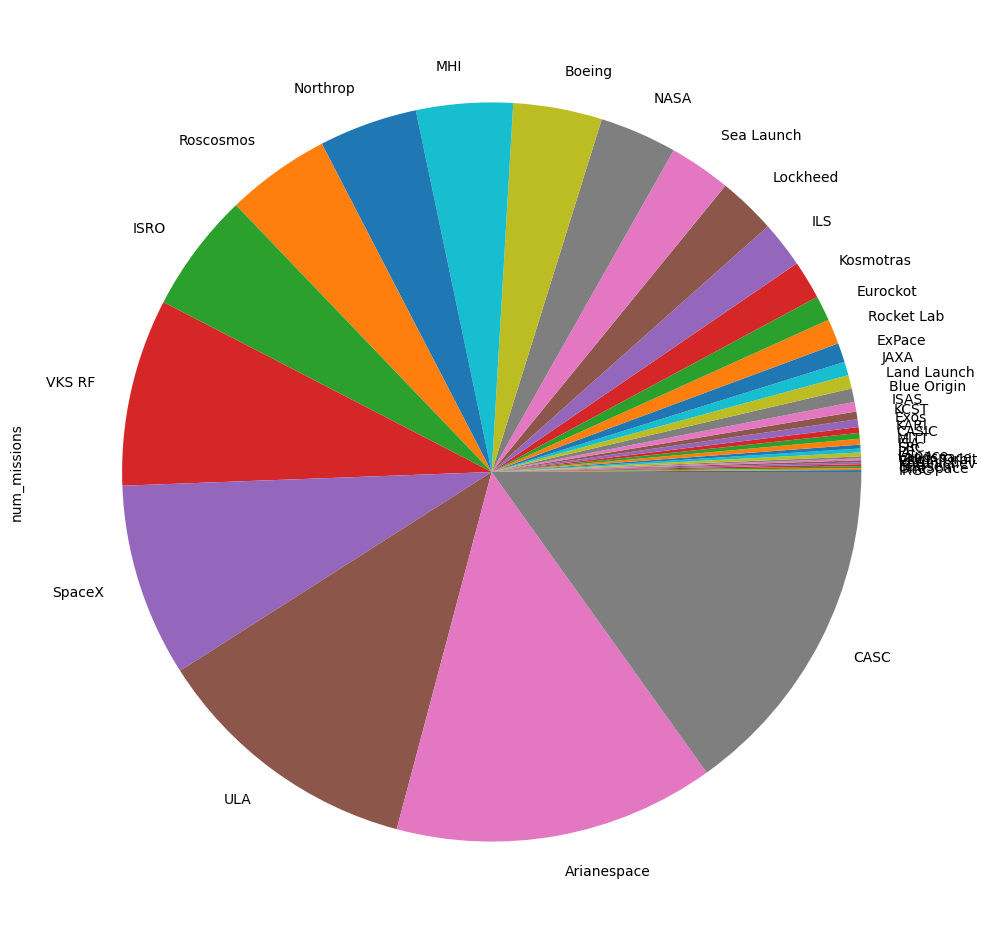

In [29]:
df_validation_pd.plot.pie(figsize=(20,12), y='num_missions', labels=df_validation_pd['company_name'], legend=False)